# FIFA 19 Machine Learning Project
### Reverse engineering FIFA's algorithm for generating players' overall ratings.

## Import Dependencies

In [82]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# LIME for explaining predictions
import lime 
import lime.lime_tabular

#Displaying Images
from IPython.display import Image

## Read in and Clean Data
#### Excluding goalkeepers, since they have their own special set of statistics.

In [83]:
# Read in data into a dataframe 
data1 = pd.read_csv('/users/samuelgiddins/desktop/fifa_ml_project/data.csv')
data = data1[data1.Position != 'GK']

# Display top of dataframe
data.head()

Age Nationality  Overall  Weak Foot  Skill Moves Position  Crossing  \
0   31   Argentina       94        4.0          4.0       RF      84.0   
1   33    Portugal       94        4.0          5.0       ST      84.0   
2   26      Brazil       92        5.0          5.0       LW      79.0   
4   27     Belgium       91        5.0          4.0      RCM      93.0   
5   27     Belgium       91        4.0          4.0       LF      81.0   

   Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  \
0       95.0             70.0          90.0     86.0       97.0   93.0   
1       94.0             89.0          81.0     87.0       88.0   81.0   
2       87.0             62.0          84.0     84.0       96.0   88.0   
4       82.0             55.0          92.0     82.0       86.0   85.0   
5       84.0             61.0          89.0     80.0       95.0   83.0   

   FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  \
0        94.0         87.0         96.0          91.0         86.0     91.0   
1        76.0         77.0         94.0          89.0         91.0     87.0   
2        87.0         78.0         95.0          94.0         90.0     96.0   
4        83.0         91.0         91.0          78.0         76.0     79.0   
5        79.0         83.0         94.0          94.0         88.0     95.0   

   Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  \
0       95.0     95.0       85.0     68.0     72.0      59.0       94.0   
1       96.0     70.0       95.0     95.0     88.0      79.0       93.0   
2       94.0     84.0       80.0     61.0     81.0      49.0       82.0   
4       91.0     77.0       91.0     63.0     90.0      75.0       91.0   
5       90.0     94.0       82.0     56.0     83.0      66.0       80.0   

   Aggression  Interceptions  Positioning  Vision  Penalties  Composure  \
0        48.0           22.0         94.0    94.0       75.0       96.0   
1        63.0           29.0         95.0    82.0       85.0       95.0   
2        56.0           36.0         89.0    87.0       81.0       94.0   
4        76.0           61.0         87.0    94.0       79.0       88.0   
5        54.0           41.0         87.0    89.0       86.0       91.0   

   Marking  StandingTackle  SlidingTackle  
0     33.0            28.0           26.0  
1     28.0            31.0           23.0  
2     27.0            24.0           33.0  
4     68.0            58.0           51.0  
5     34.0            27.0           22.0

#### Examine data

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16182 entries, 0 to 18206
Data columns (total 35 columns):
Age                16182 non-null int64
Nationality        16182 non-null object
Overall            16182 non-null int64
Weak Foot          16134 non-null float64
Skill Moves        16134 non-null float64
Position           16122 non-null object
Crossing           16134 non-null float64
Finishing          16134 non-null float64
HeadingAccuracy    16134 non-null float64
ShortPassing       16134 non-null float64
Volleys            16134 non-null float64
Dribbling          16134 non-null float64
Curve              16134 non-null float64
FKAccuracy         16134 non-null float64
LongPassing        16134 non-null float64
BallControl        16134 non-null float64
Acceleration       16134 non-null float64
SprintSpeed        16134 non-null float64
Agility            16134 non-null float64
Reactions          16134 non-null float64
Balance            16134 non-null float64
ShotPower      

## Convert any Incorrect Data Types
#### Convert anything that says "Not Available" to np.nan, which Python can interpret as a float.

In [85]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

In [86]:
# Statistics for each column
data.describe()

Age       Overall     Weak Foot   Skill Moves      Crossing  \
count  16182.000000  16182.000000  16134.000000  16134.000000  16134.000000   
mean      25.006921     66.443332      3.004711      2.532168     54.186934   
std        4.547772      6.790578      0.636872      0.617861     14.134880   
min       16.000000     46.000000      1.000000      1.000000     11.000000   
25%       21.000000     62.000000      3.000000      2.000000     44.000000   
50%       25.000000     66.000000      3.000000      2.000000     56.000000   
75%       28.000000     71.000000      3.000000      3.000000     65.000000   
max       41.000000     94.000000      5.000000      5.000000     93.000000   

          Finishing  HeadingAccuracy  ShortPassing       Volleys  \
count  16134.000000     16134.000000  16134.000000  16134.000000   
mean      49.759886        57.058696     62.629974     46.738627   
std       16.378068        11.610103      9.799974     14.783629   
min       10.000000        15.000000     20.000000     10.000000   
25%       36.000000        49.000000     57.000000     35.000000   
50%       52.000000        58.000000     64.000000     47.000000   
75%       63.000000        65.000000     69.000000     58.000000   
max       95.000000        94.000000     93.000000     90.000000   

          Dribbling         Curve    FKAccuracy   LongPassing   BallControl  \
count  16134.000000  16134.000000  16134.000000  16134.000000  16134.000000   
mean      60.581567     51.245320     46.427544     56.088633     63.191583   
std       12.517509     15.148884     15.072031     12.397783     10.025495   
min       14.000000     11.000000     10.000000     19.000000     13.000000   
25%       55.000000     39.000000     34.000000     49.000000     58.000000   
50%       63.000000     52.000000     44.000000     58.000000     64.000000   
75%       69.000000     63.000000     58.000000     65.000000     70.000000   
max       97.000000     94.000000     94.000000     93.000000     96.000000   

       Acceleration   SprintSpeed       Agility     Reactions       Balance  \
count  16134.000000  16134.000000  16134.000000  16134.000000  16134.000000   
mean      67.914280     67.992128     66.428288     62.201872     66.585782   
std       11.743521     11.464319     12.341357      8.767334     12.169898   
min       20.000000     25.000000     23.000000     21.000000     22.000000   
25%       62.000000     62.000000     59.000000     56.000000     60.000000   
50%       69.000000     69.000000     68.000000     62.000000     68.000000   
75%       76.000000     76.000000     75.000000     68.000000     75.000000   
max       97.000000     96.000000     96.000000     96.000000     96.000000   

          ShotPower       Jumping       Stamina      Strength     LongShots  \
count  16134.000000  16134.000000  16134.000000  16134.000000  16134.000000   
mean      59.592723     66.017107     67.331474     65.903000     51.434672   
std       13.238115     11.530177     11.184204     12.603276     15.730354   
min       13.000000     28.000000     27.000000     25.000000     11.000000   
25%       51.000000     59.000000     61.000000     59.000000     40.000000   
50%       61.000000     67.000000     68.000000     67.000000     54.000000   
75%       69.000000     74.000000     75.000000     75.000000     64.000000   
max       95.000000     95.000000     96.000000     97.000000     94.000000   

         Aggression  Interceptions   Positioning        Vision     Penalties  \
count  16134.000000   16134.000000  16134.000000  16134.000000  16134.000000   
mean      59.571216      50.419177     54.815731     55.459712     52.130842   
std       14.452953      18.800294     14.679242     12.915172     12.514460   
min       13.000000      10.000000     11.000000     12.000000     12.000000   
25%       50.000000      34.000000     46.000000     47.000000     42.000000   
50%       61.000000      56.000000     57.000000     57.000000     52.00000

## Check out missing value statistics
#### This will give us an idea of what we'll later have to handle for ML methods.

In [87]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [88]:
missing_values_table(data)

Your selected dataframe has 35 columns.
There are 32 columns that have missing values.


Missing Values  % of Total Values
Position                     60                0.4
Weak Foot                    48                0.3
Balance                      48                0.3
StandingTackle               48                0.3
Marking                      48                0.3
Composure                    48                0.3
Penalties                    48                0.3
Vision                       48                0.3
Positioning                  48                0.3
Interceptions                48                0.3
Aggression                   48                0.3
LongShots                    48                0.3
Strength                     48                0.3
Stamina                      48                0.3
Jumping                      48                0.3
ShotPower                    48                0.3
Reactions                    48                0.3
Skill Moves                  48                0.3
Agility                      48                0.3
SprintSpeed                  48                0.3
Acceleration                 48                0.3
BallControl                  48                0.3
LongPassing                  48                0.3
FKAccuracy                   48                0.3
Curve                        48                0.3
Dribbling                    48                0.3
Volleys                      48                0.3
ShortPassing                 48                0.3
HeadingAccuracy              48                0.3
Finishing                    48                0.3
Crossing                     48                0.3
SlidingTackle                48                0.3

## Preliminary Data Analysis
#### Looking for some initial correlations/trends to help inform ML. Of course, we want to focus on overall rating as the dependent variable.

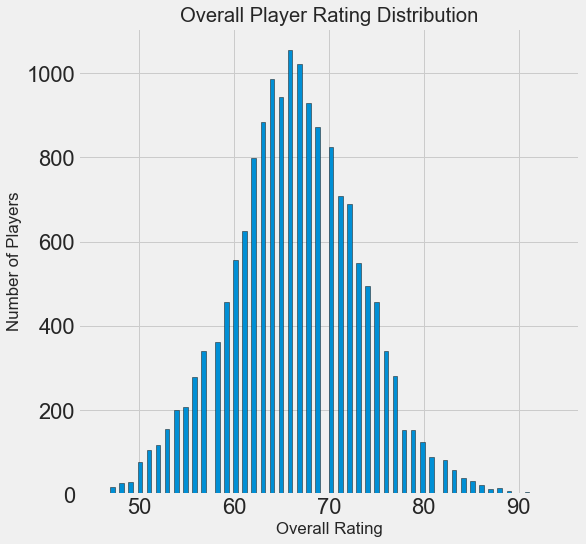

In [89]:
#First, check out the distribution of player ratings to make sure there isn't anything crazy going on.
figsize(8, 8)

# Histogram of Player Ratings
plt.style.use('fivethirtyeight')
plt.hist(data['Overall'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Overall Rating'); plt.ylabel('Number of Players'); 
plt.title('Overall Player Rating Distribution');

#### The ratings seem to be very normally distributed -- this is promising! We shouldn't have any outliers to deal with, which is nice.

### Looking for Correlations
#### With the next couple plots, we will look to see if either of the categorical variables in our dataset seem to influence overall rating. A density plot can show us how the distribution of overall rating changes based on a category. To prevent the graph from being too crowded, we'll limit it to only show nationalities that have at least 100 players in the dataset. Then, we'll repeat the process with player position.

In [90]:
# Create a list of nationalities with more than 100 players
nationalities = data.dropna(subset=['Overall'])
nationalities = nationalities['Nationality'].value_counts()
nationalities = list(nationalities[nationalities.values > 100].index)

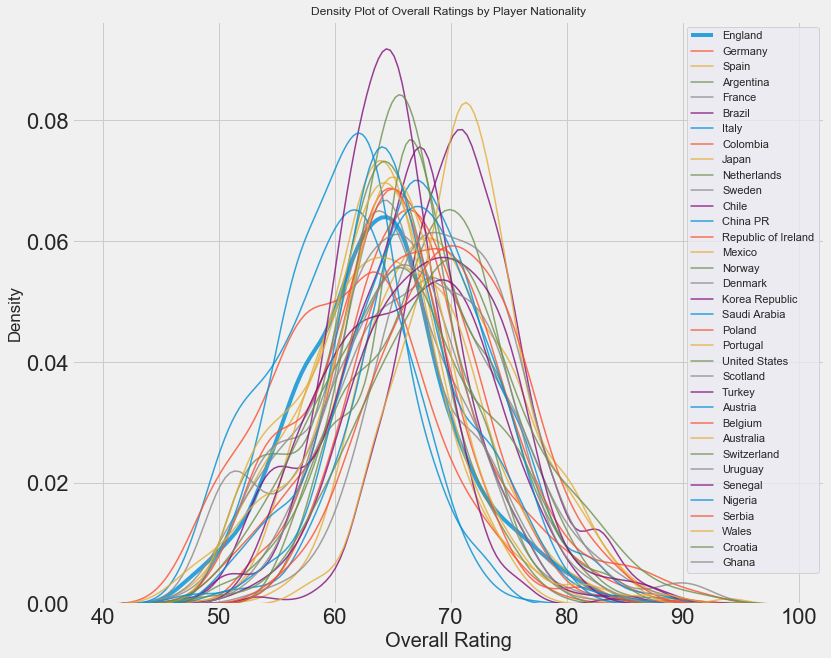

In [91]:
# Plot of distribution of ratings for different nations
figsize(12, 10)

# Plot each record
for n in nationalities:
    # Select the nationality
    subset = data[data['Nationality'] == n]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['Overall'].dropna(),
               label = n, shade = False, alpha = 0.8);
    sns.set(rc={'figure.figsize':(10,10)})
    
# label the plot
plt.xlabel('Overall Rating', size = 20); plt.ylabel('Density'); 
plt.title('Density Plot of Overall Ratings by Player Nationality');

#### Obviously, it's tough to derive any detailed conclusions from this, but we see that some nationalities peak further right on the graph and some peak further left, which suggests that some nations have higher concentrations of highly rated players than others. Now, well do the same plot and check out positions.

In [92]:
# Create a list of positions with more than 100 observations
positions = data.dropna(subset=['Overall'])
positions = positions['Position'].value_counts()
positions = list(positions[positions.values > 100].index)

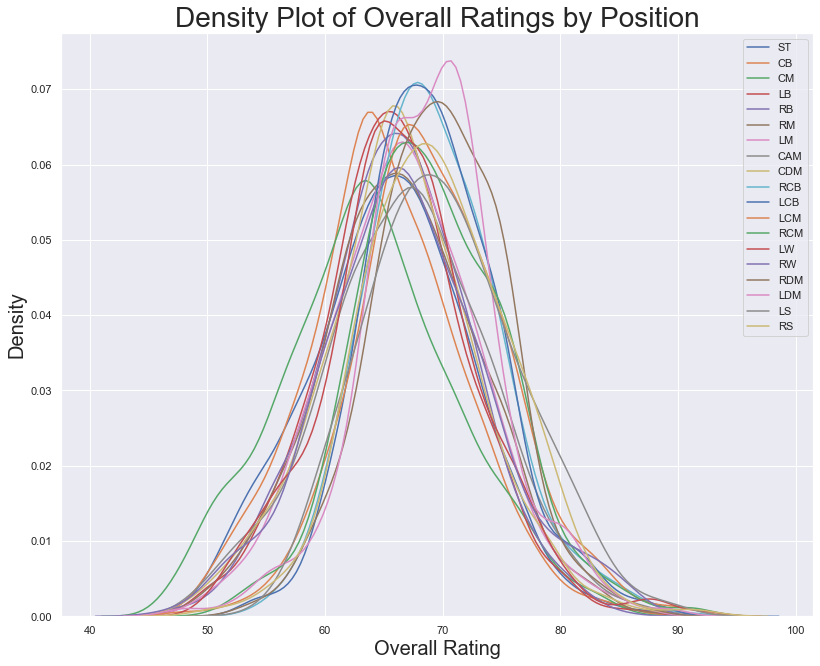

In [93]:
# Plot of distribution of ratings for positions
figsize(12, 10)

# Plot each position distribution of ratings
for p in positions:
    # Select the position
    subset = data[data['Position'] == p]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['Overall'].dropna(),
               label = p);
    
# label the plot
plt.xlabel('Overall Rating', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Overall Ratings by Position', size = 28);

#### It looks like Left Mids have the highest ratings and attacking players tend to be more highly rated than defensive players. Interesting!

## Initial Correlation Coefficients
#### Looking for the strongest initial linear relationships between independent variables and dependent variable (overall rating).

In [94]:
# Find all correlations and sort 
correlations_data = data.corr()['Overall'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Balance           0.059504
Acceleration      0.150621
SprintSpeed       0.169926
Weak Foot         0.208897
SlidingTackle     0.224896
Jumping           0.228382
Agility           0.244126
StandingTackle    0.264510
Marking           0.305991
Interceptions     0.333576
Strength          0.341123
Finishing         0.373000
Penalties         0.390954
Positioning       0.438786
Volleys           0.452038
Name: Overall, dtype: float64 

Stamina            0.461547
HeadingAccuracy    0.467296
Crossing           0.496814
LongShots          0.502207
Curve              0.503084
Skill Moves        0.505436
Dribbling          0.516518
Vision             0.524665
ShotPower          0.562941
LongPassing        0.585374
BallControl        0.717802
ShortPassing       0.722615
Composure          0.801772
Reactions          0.847722
Overall            1.000000
Name: Overall, dtype: float64


#### It looks like reactions and composure have the strongest linear relationships to overall rating. Now we'll add square roots and logs to numeric features to try and account for potential non-linear relationships. We'll also one-hot encode the categorical variables so we can start to analyze them as independent variables.

In [97]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Overall column
    if col == 'Overall':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Nationality', 'Position']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop records without an overall rating
features = features.dropna(subset = ['Overall'])

# Find correlations with the overall rating 
correlations = features.corr()['Overall'].dropna().sort_values()

In [98]:
# Display most negative correlations
correlations.head(15)

Nationality_China PR              -0.139692
Nationality_England               -0.133621
Position_CM                       -0.122704
Nationality_Republic of Ireland   -0.114773
Nationality_Saudi Arabia          -0.108857
Nationality_Japan                 -0.079945
Position_CB                       -0.073398
Nationality_Norway                -0.062768
Nationality_Australia             -0.061853
Nationality_Sweden                -0.057514
Nationality_Poland                -0.054513
Position_ST                       -0.052344
Nationality_Denmark               -0.052030
Nationality_India                 -0.046820
Nationality_Korea Republic        -0.045699
Name: Overall, dtype: float64

In [99]:
# Display most positive correlations
correlations.tail(15)

sqrt_LongPassing     0.570155
LongPassing          0.585374
log_BallControl      0.675733
log_ShortPassing     0.690010
sqrt_BallControl     0.699068
sqrt_ShortPassing    0.708399
BallControl          0.717802
ShortPassing         0.722615
log_Composure        0.790157
sqrt_Composure       0.797235
Composure            0.801772
log_Reactions        0.833201
sqrt_Reactions       0.841802
Reactions            0.847722
Overall              1.000000
Name: Overall, dtype: float64

#### Looks like the strongest relationships are still with numeric columns, and for each variable, the original number provides the strongest correlation as opposed to its log or square root.

## Two-variable plot of strong independent variables
#### Another visualization of the relationships between the strongest features and the target

//anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


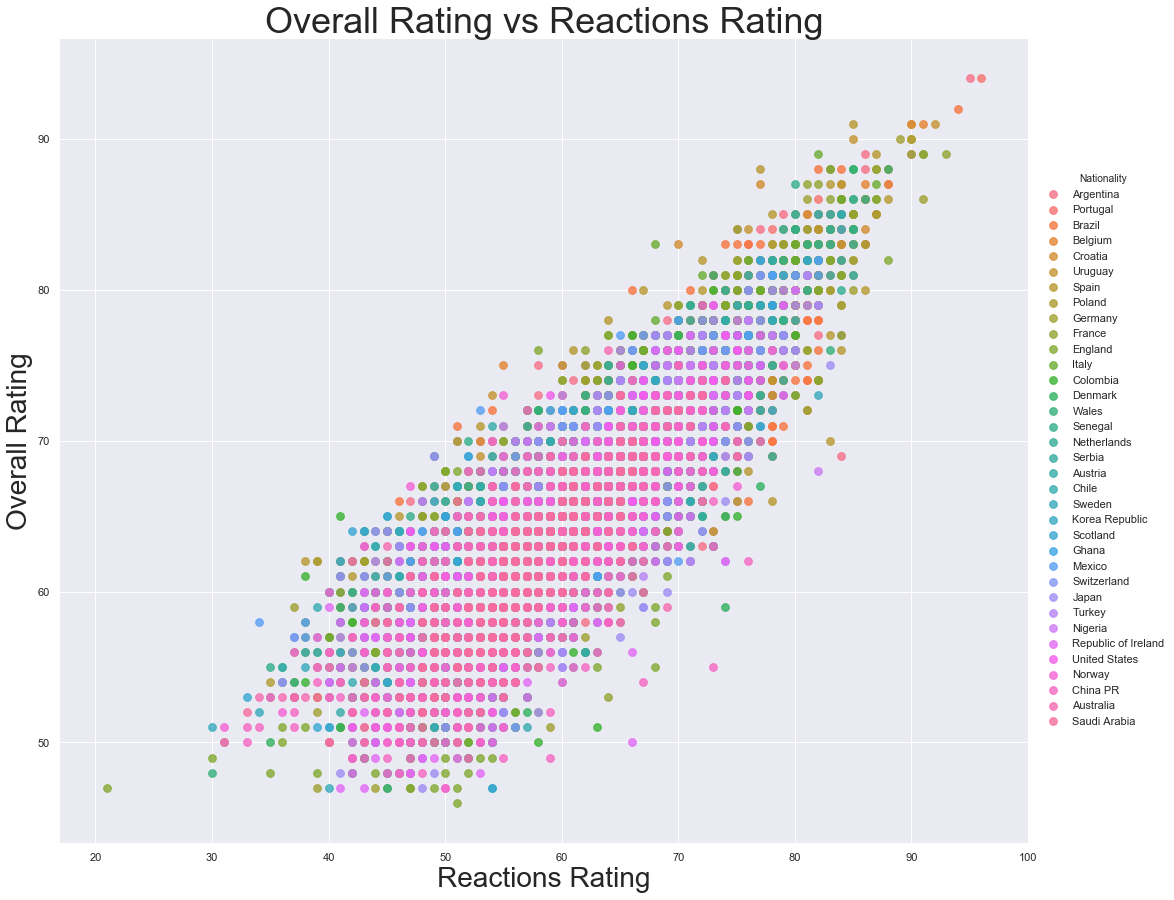

In [100]:
figsize(12, 10)

# Extract the nationalities
features['Nationality'] = data.dropna(subset = ['Overall'])['Nationality']

# Limit to building types with more than 100 observations (from previous code)
features = features[features['Nationality'].isin(nationalities)]

# Use seaborn to plot a scatterplot of Overall Rating vs Reactions
sns.lmplot('Reactions', 'Overall', 
          hue = 'Nationality', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Reactions Rating", size = 28)
plt.ylabel('Overall Rating', size = 28)
plt.title('Overall Rating vs Reactions Rating', size = 36);

#### As our correlation coefficient suggested, there's a very strong positive relationship between reaction rating and overall rating.

## Pairs Plot
#### With a pairs plot, we can explore many different independent variables at once. We'll have histograms of single variables on the diagonal for reference. The upper triangle will be scatterplots between two variables and the lower triangle will show density estimates and a correlation coefficient.

In [101]:
# # Don't run this slide during presentation -- display png of graph instead in next cell
# # Extract the columns to  plot
# plot_data = features[['Overall', 'Reactions', 
#                       'Composure', 
#                       'ShortPassing']]

# # Replace the inf with nan
# plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# # Drop na values
# plot_data = plot_data.dropna()

# # Function to calculate correlation coefficient between two columns
# def corr_func(x, y, **kwargs):
#     r = np.corrcoef(x, y)[0][1]
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.2, .8), xycoords=ax.transAxes,
#                 size = 20)

# # Create the pairgrid object
# grid = sns.PairGrid(data = plot_data, size = 3)

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# # Diagonal is a histogram
# grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# # Bottom is correlation and density plot
# grid.map_lower(corr_func);
# grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# # Title for entire plot
# plt.suptitle('Pairs Plot of FIFA Attributes', size = 36, y = 1.02);
# plt.savefig('fifa_pairs_plot.png')

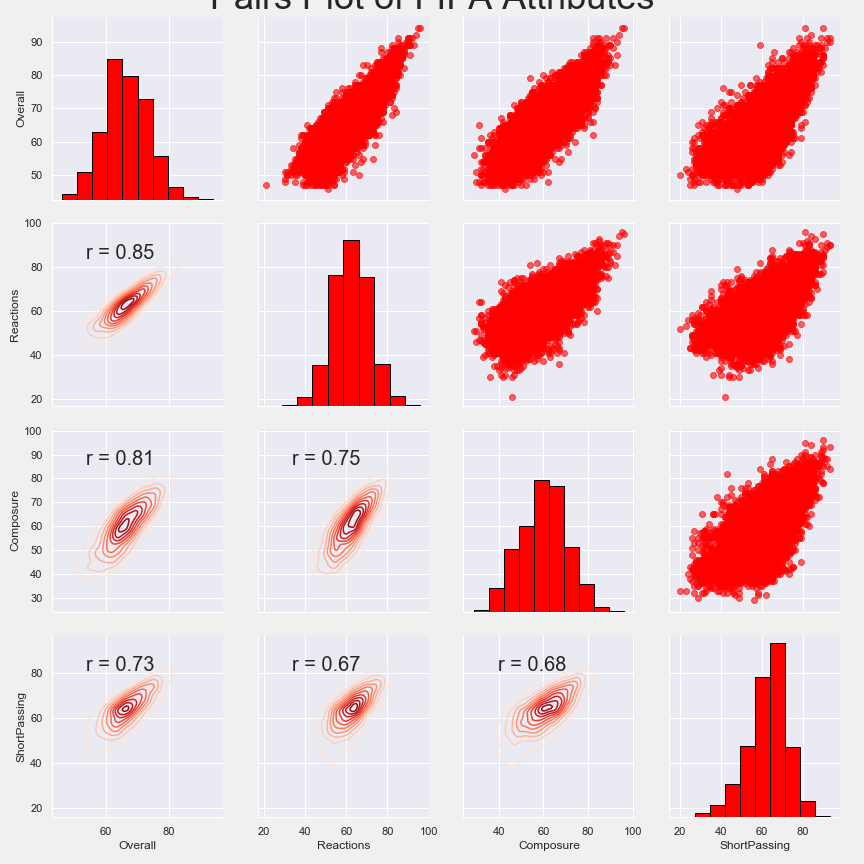

In [102]:
# Display the tree
Image(filename='/users/samuelgiddins/desktop/fifa_ml_project/fifa_pairs_plot.png')

#### A lot of normal distributions and linear-looking relationships. This is what we like to see!

## Feature Engineering/Feature Selection
#### Now that we've done some exploratory data analysis, lets start prepping features for machine learning and identifying which ones will be most relevant. For the sake of run speed, we're going to skip the logs, square roots and categorical data this time around. We've already identified that the logs, square roots, and categorical variables probably won't make our model any better, and we're not particularly interested in the categorical data anyway. 

In [103]:
data = data1[data1.Position != 'GK']

In [104]:
data = data.drop(['Nationality', 'Position'], axis=1)

In [105]:
features = data.copy()

features.shape

(16182, 33)

#### We don't have any collinear features, so we don't need to remove anything right now.

## Train, Test, Split
#### Generate a training set to give out model that includes answers, so the model can start to learn a mapping between features and targets. Also generate a testing set which we use to evaluate the mapping the model learned with the training data.

In [106]:
# Extract the players with no ratings and the players with a rating 
# This will probably not actually do anything, but doesn't hurt to be extra careful
no_rating = features[features['Overall'].isna()]
rating = features[features['Overall'].notnull()]

print(no_rating.shape)
print(rating.shape)

(0, 33)
(16182, 33)


In [107]:
# Separate out the features and targets
features = rating.drop(columns='Overall')
targets = pd.DataFrame(rating['Overall'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(11327, 32)
(4855, 32)
(11327, 1)
(4855, 1)


## Establish a Naive Baseline
#### If our model can't outperform a naive guess, then this problem probably isn't well-suited for machine learning. For our baseline, we'll use the median value of the target on the training set for all examples on the test set. We'll use the Mean Absolute Error (MAE) as a metric of performance -- the lower the better.

In [108]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [109]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 5.2803


In [110]:
# Checkpoint: Save all the new data to CSV's to be able to read in and pick up where we left off
no_rating.to_csv('/users/samuelgiddins/desktop/fifa_ml_project/no_rating.csv', index = False)
X.to_csv('/users/samuelgiddins/desktop/fifa_ml_project/training_features.csv', index = False)
X_test.to_csv('/users/samuelgiddins/desktop/fifa_ml_project/testing_features.csv', index = False)
y.to_csv('/users/samuelgiddins/desktop/fifa_ml_project/training_labels.csv', index = False)
y_test.to_csv('/users/samuelgiddins/desktop/fifa_ml_project/testing_labels.csv', index = False)

In [111]:
# Pick up where we left off
# Read in data into dataframes 
train_features = pd.read_csv('/users/samuelgiddins/desktop/fifa_ml_project/training_features.csv')
test_features = pd.read_csv('/users/samuelgiddins/desktop/fifa_ml_project/testing_features.csv')
train_labels = pd.read_csv('/users/samuelgiddins/desktop/fifa_ml_project/training_labels.csv')
test_labels = pd.read_csv('/users/samuelgiddins/desktop/fifa_ml_project/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (11327, 32)
Testing Feature Size:   (4855, 32)
Training Labels Size:   (11327, 1)
Testing Labels Size:    (4855, 1)


## Picking the right Machine Learning Model
#### We'll again use MAE to evaluate model performance.

## Impute missing values
#### Fills in missing values with the median of the column -- ML can't handle missing values

In [112]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [113]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [114]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Scale Features
#### If features are in different units, we want to normalize them so that they don't affect the algorithm.

In [115]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [116]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Evaluating models

In [117]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [118]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 1.9488


In [119]:
# Don't run during presentation - takes too long
# svm = SVR(C = 1000, gamma = 0.1)
# svm_mae = fit_and_evaluate(svm)

# print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

In [120]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 1.1034


In [121]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 1.0475


In [122]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 1.4194


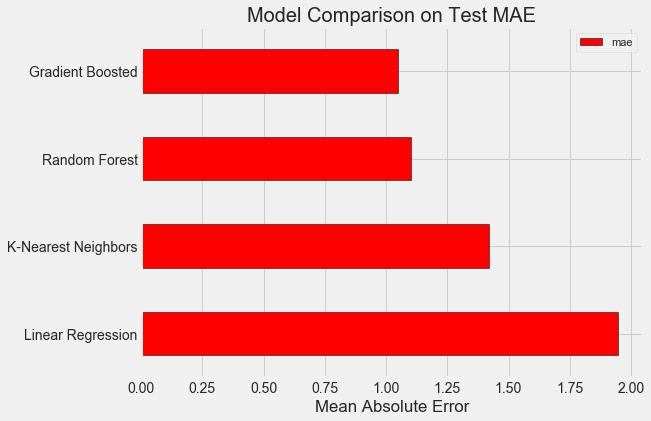

In [123]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

#### So, SVM actually performed the best, and we should technically be using it as our final model moving forward. I"m going to cut corners for the sake of run speed, and use gradient-boosted instead. The SVM regression took many minutes to run while the gradient boosted only took a couple seconds, and the gradient boosted still performed extremely well. Here I'm sacrificing a little bit of precision for time, as I'll have to come back and run these cells again and again and can't afford to wait minutes every single time.

## Optimizing the model
#### We will pick which model components we want to fine tune by using "random search" and "cross validation." In random search, we choose which components we want to evaluate. Cross validation is a more calculated way of assessing the performance of the components. 

In [124]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [125]:
# # Create the model to use for hyperparameter tuning
# model = GradientBoostingRegressor(random_state = 42)

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=model,
#                                param_distributions=hyperparameter_grid,
#                                cv=4, n_iter=25, 
#                                scoring = 'neg_mean_absolute_error',
#                                n_jobs = -1, verbose = 1, 
#                                return_train_score = True,
#                                random_state=42)

In [126]:
# Fit on the training data
# # We will comment this out after we pickle it.
# random_cv.fit(X, y)

In [127]:
# Pickle random_cv so we don't have to wait for it to load every time.
import pickle
# f = open("random_cv.pickle", "ab")
# pickle.dump(random_cv, f) 
# f.close()
rand_cv_file = open('random_cv.pickle', "rb")
random_cv = pickle.load(rand_cv_file)

In [128]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16      48.890797      0.348680         0.078327        0.002799   
22      94.089477      1.156659         0.160842        0.066016   
21      10.278100      0.261596         0.045961        0.004002   
3       31.735129      0.249567         0.041504        0.000460   
5       13.643928      0.185273         0.070302        0.004843   
9       17.541628      0.400631         0.031452        0.001547   
7       14.609265      0.413323         0.029637        0.000185   
12      37.122088      1.012000         0.041204        0.002897   
13      25.001629      2.720251         0.105811        0.011157   
1        8.670890      0.174315         0.022795        0.000596   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
16               1500                       4                      6   
22               1500                       2                      8   
21                500                       6                      4   
3                 500                       6                      8   
5                 900                       6                      8   
9                 500                       4                      2   
7                 500                       4                      6   
12                500                       6                      6   
13               1500                      10                      1   
1                 100                       6                      8   

   param_max_features param_max_depth param_loss  \
16               None               3         ls   
22               None               5         ls   
21               log2               5      huber   
3                None               5      huber   
5                log2               5        lad   
9                auto               3      huber   
7                auto               3         ls   
12               None               5        lad   
13               sqrt               5        lad   
1                sqrt              10      huber   

                                               params  split0_test_score  \
16  {'n_estimators': 1500, 'min_samples_split': 4,...          -0.760298   
22  {'n_estimators': 1500, 'min_samples_split': 2,...          -0.782251   
21  {'n_estimators': 500, 'min_samples_split': 6, ...          -0.795324   
3   {'n_estimators': 500, 'min_samples_split': 6, ...          -0.779352   
5   {'n_estimators': 900, 'min_samples_split': 6, ...          -0.841587   
9   {'n_estimators': 500, 'min_samples_split': 4, ...          -0.818194   
7   {'n_estimators': 500, 'min_samples_split': 4, ...          -0.817436   
12  {'n_estimators': 500, 'min_samples_split': 6, ...          -0.831834   
13  {'n_estimators': 1500, 'min_samples_split': 10...          -0.852602   
1   {'n_estimators': 100, 'min_samples_split': 6, ...          -0.840757   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
16          -0.765752          -0.755840          -0.760693        -0.760646   
22          -0.795773          -0.792682          -0.762817        -0.783382   
21          -0.788094          -0.773166          -0.785842        -0.785607   
3           -0.802719          -0.790433          -0.787112        -0.789904   
5           -0.811842          -0.807633          -0.804634        -0.816425   
9           -0.816501          -0.817005          -0.815768        -0.816867   
7           -0.823767          -0.814695          -0.815942        -0.817960   
12          -0.837937          -0.824251          -0.802869        -0.824225   
13          -0.827324          -0.830484          -0.823092        -0.833376   
1           -0.839504          -0.830868          -0.826763        -0.834474   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
16        0.003511                1           -0.440906           -0.449374   
22        0.0

In [129]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### So, the best gradient boosted model has the following hyperparameters:
#### loss = ls, n_estimators = 1500, max_depth = 3, min_samples_leaf = 6, min_samples_split = 4, max_features = None
#### Now, we can check for the effect of a single hyperparameter by using the optimized components from the previous method. We'll evaluate a range of trees in the random forest (n_estimators) and set the other hyperparameters as optimized to isolate the effects of the n_estimator hyperparameter.

In [132]:
# # Create a range of trees to evaluate
# trees_grid = {'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1500, 1700, 1800, 2000, 2100, 2300, 2500]}

# model = GradientBoostingRegressor(loss = 'ls', max_depth = 3,
#                                   min_samples_leaf = 6,
#                                   min_samples_split = 4,
#                                   max_features = None,
#                                   random_state = 42)

# # Grid Search Object using the trees range and the random forest model
# grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
#                            scoring = 'neg_mean_absolute_error', verbose = 1,
#                            n_jobs = -1, return_train_score = True)

In [133]:
# Fit the grid search
# We will comment this out after we pickle it.
# grid_search.fit(X, y)

In [134]:
# Pickle grid_search so we don't have to wait for it to load every time.
# import pickle
# f = open("grid_search.pickle", "ab")
# pickle.dump(grid_search, f) 
# f.close()
grid_search_file = open('grid_search.pickle', "rb")
grid_search = pickle.load(grid_search_file)

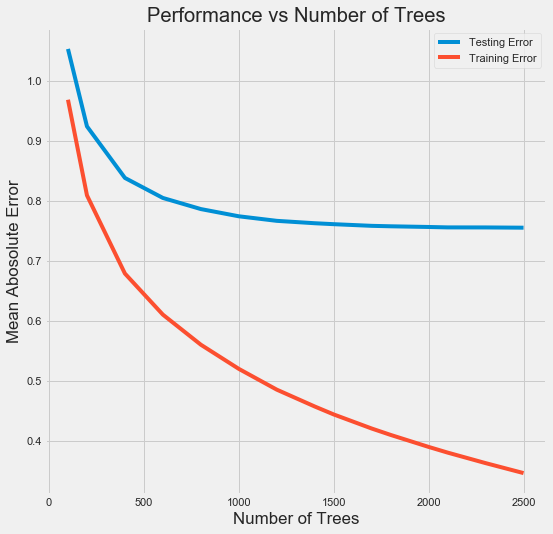

In [135]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [136]:
results.sort_values('mean_test_score', ascending = False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14      79.724742      0.896396         0.112502        0.017026   
13      73.833370      0.944954         0.123653        0.006019   
12      68.179646      0.422960         0.111573        0.003758   
11      64.041695      0.983152         0.108429        0.004067   
10      66.617111      0.437455         0.120081        0.016729   

   param_n_estimators                  params  split0_test_score  \
14               2500  {'n_estimators': 2500}          -0.755679   
13               2300  {'n_estimators': 2300}          -0.756009   
12               2100  {'n_estimators': 2100}          -0.756703   
11               2000  {'n_estimators': 2000}          -0.757962   
10               1800  {'n_estimators': 1800}          -0.757296   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
14          -0.757322          -0.751073          -0.755118        -0.754798   
13          -0.756733          -0.751659          -0.756471        -0.755218   
12          -0.756172          -0.752022          -0.756276        -0.755293   
11          -0.756882          -0.752342          -0.756766        -0.755988   
10          -0.759935          -0.752997          -0.758308        -0.757134   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
14        0.002298                1           -0.343587           -0.351753   
13        0.002071                2           -0.359845           -0.368632   
12        0.001899                3           -0.377275           -0.386211   
11        0.002156                4           -0.386949           -0.395552   
10        0.002568                5           -0.405811           -0.414903   

    split2_train_score  split3_train_score  mean_train_score  std_train_score  
14           -0.347064           -0.340856         -0.345815         0.004073  
13           -0.363662           -0.357633         -0.362443         0.004174  
12           -0.381706           -0.374682         -0.379969         0.004393  
11           -0.391104           -0.384144         -0.389437         0.004312  
10           -0.412231           -0.404732         -0.409419         0.004271

#### So yes, our model is overfitting a bit -- it's learning the training data very well but isn't generalizing the test data quite as well. We'll accept the slight overfitting for this instance. 
#### The above results show that the model using 2500 trees achieves a cross validation error of less than 1 which, in theory, indicates that the average-estimate of this model is within a single point of the true answer!


## Evaluating our final model on the test data

In [137]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=2500,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [138]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

1.43 s ± 34.9 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [139]:
# # We will comment out the fit of the final model once we've pickled it.
# %%timeit -n 1 -r 5
# final_model.fit(X, y)

In [140]:
# Pickle final_model so we don't have to wait for it to load every time.
# import pickle
# f = open("final_model.pickle", "ab")
# pickle.dump(final_model, f) 
# f.close()
final_model_file = open('final_model.pickle', "rb")
final_model = pickle.load(final_model_file)

In [141]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 1.0475.
Final model performance on the test set:   MAE = 0.7341.


#### Yay! The final model performs about 30% better than the default model.

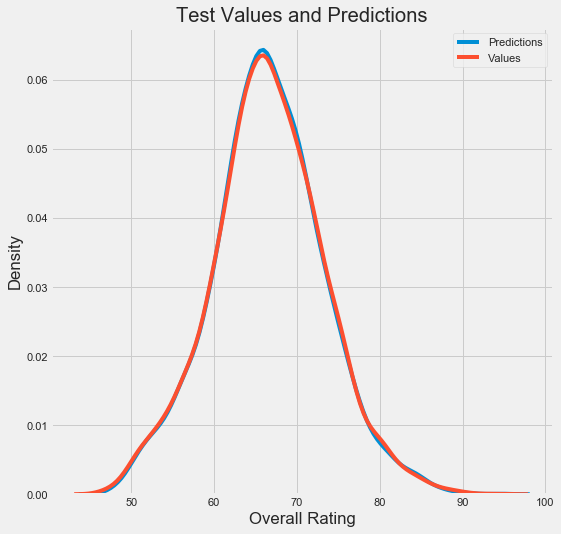

In [142]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Overall Rating'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

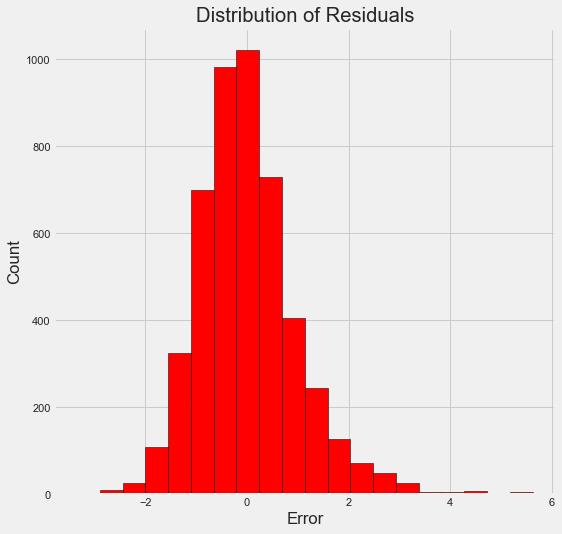

In [143]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

#### Predictions and actual values are nearly identical and distribution of residuals is very normal. All good!

## Interpreting the Model
#### First, I'm going to recreate the final model just to make sure everything is buttoned up for final analysis.

In [144]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [145]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [146]:
# Comment this out after pickling
# model = GradientBoostingRegressor(loss='ls', max_depth=3, max_features=None,
#                                   min_samples_leaf=6, min_samples_split=4, 
#                                   n_estimators=2500, random_state=42)

# model.fit(X, y)

In [147]:
# Pickle model so we don't have to wait for it to load every time.
# import pickle
# f = open("model.pickle", "ab")
# pickle.dump(model, f) 
# f.close()
model_file = open('model.pickle', "rb")
model = pickle.load(model_file)

In [148]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 0.7342


## Feature Importances
#### Display which variables are most predictive of the target in the final model

In [149]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

feature  importance
0        Reactions    0.466370
1      BallControl    0.140554
2        Composure    0.128671
3   StandingTackle    0.052737
4  HeadingAccuracy    0.033028
5          Marking    0.023865
6     ShortPassing    0.022182
7        Dribbling    0.014462
8    SlidingTackle    0.013753
9    Interceptions    0.012933

In [150]:
feature_results

feature  importance
0         Reactions    0.466370
1       BallControl    0.140554
2         Composure    0.128671
3    StandingTackle    0.052737
4   HeadingAccuracy    0.033028
5           Marking    0.023865
6      ShortPassing    0.022182
7         Dribbling    0.014462
8     SlidingTackle    0.013753
9     Interceptions    0.012933
10         Crossing    0.012803
11        ShotPower    0.012714
12              Age    0.010194
13        Finishing    0.009472
14          Stamina    0.009384
15      Positioning    0.009081
16         Strength    0.008222
17      SprintSpeed    0.006677
18     Acceleration    0.003914
19           Vision    0.002583
20       Aggression    0.001429
21      LongPassing    0.001135
22          Jumping    0.000887
23        LongShots    0.000806
24          Volleys    0.000532
25          Agility    0.000363
26          Balance    0.000316
27            Curve    0.000308
28        Penalties    0.000291
29       FKAccuracy    0.000220
30      Skill Moves    0.000072
31        Weak Foot    0.000040

#### Reactions is the most important feature by a huge margin. After that it's ball control and composure, and there's another dropoff after that.

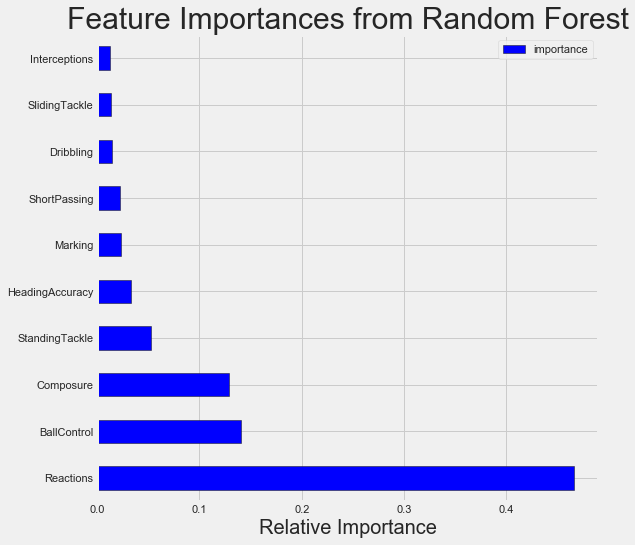

In [151]:
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

#### Realistically, not every feature in the dataset is going to be relevant for predicting the target. So, lets see what happens if we reduce the data to the 10 most important features and then perform a linear regression with all those. Then we can do the same thing and apply the limited features to our random forest and see if it boosts performance.

In [152]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (11327, 10)
Most important testing  features shape:  (4855, 10)


In [153]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    1.9488.
Linear Regression Reduced Results: MAE = 2.1587.


#### Reducing the features and using linear regression didn't improve performance. Now we'll try it with the gradient boosted regression model.

In [154]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=3, max_features=None,
                                  min_samples_leaf=6, min_samples_split=4, 
                                  n_estimators=2500, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 1.2418


#### Again, limiting the features with the gradient boosted regression also didn't help performance. We'll keep all the features in our final model.

## Locally Interpretable Model-agnostic Explanations (LIME)
#### LIME aims to show how a machine learning model thinks by approximating around a prediction with a linear model. Here, we'll try to explain how our model predicts around a wrong sample of predicitions and then compare to what it says for a sample of predictions that it gets right. 

In [155]:
# Find the residuals
residuals = abs(model_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test[np.argmax(residuals), :]
right = X_test[np.argmin(residuals), :]

In [156]:
# Reload the pickled model because we reduced it before
model = pickle.load(model_file)
model_pred = model.predict(X_test)

print('Gradient Boosted Regression Results: MAE = %0.4f' % mae(y_test, model_pred))

Gradient Boosted Regression Results: MAE = 0.7342


In [157]:
model.score(X_test, y_test)

0.9787987475585151

In [158]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(features))

Prediction: 71.6208
Actual Value: 66.0000


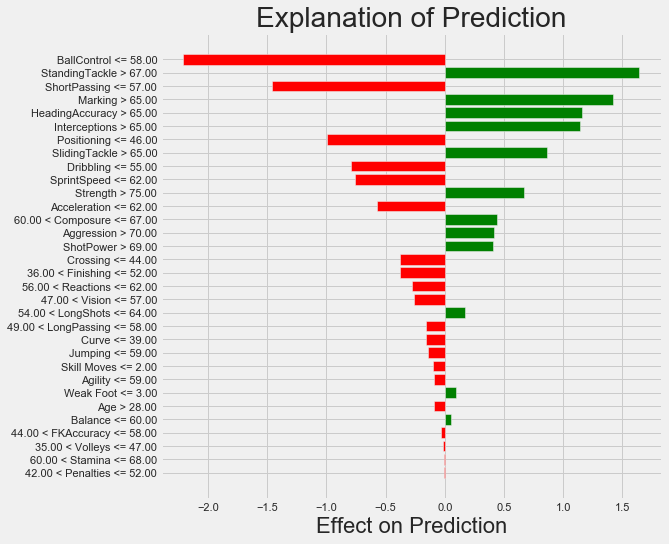

In [160]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model.predict, num_features=32)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [161]:
wrong_exp.show_in_notebook(show_predicted_value=False)

#### Now, we can look at a value that the model gets right.

Prediction: 65.9997
Actual Value: 66.0000


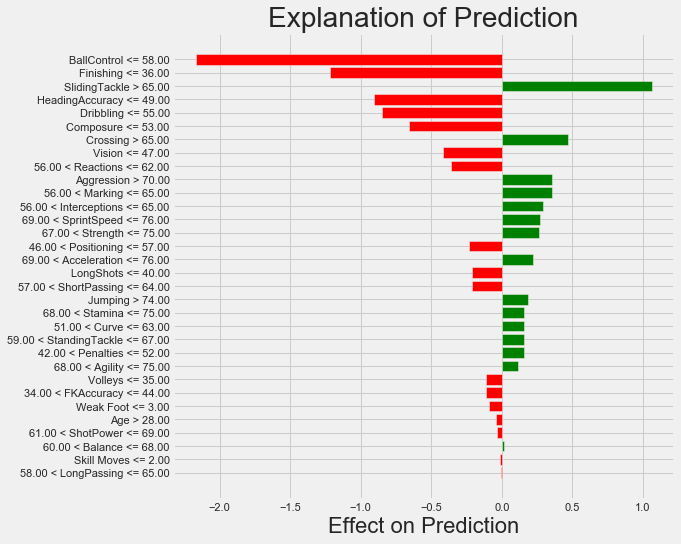

In [162]:
# Display the predicted and true value for the right instance
print('Prediction: %0.4f' % model.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for right prediction
right_exp = explainer.explain_instance(right, model.predict, num_features=32)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [163]:
right_exp.show_in_notebook(show_predicted_value=False)

## Conclusion
#### It seems like FIFA holds a lot of importance in a couple of attributes when it generates a player's rating, reactions, composure, and heading accuracy to name a few. 
#### Our model generally does a great job of predicting players' ratings. It seems like when it's getting predictions wrong is when the player ratings are very low and when it's a bit unclear what the player's purpose is. For example, it will likely do a better job of predicting ratings for premier forwards than for bottom-bucket defensive midfielders. But, overall, it does a great job.
#### To close out this project, we'll look at one of the single decision trees of our algorithm that contributed to the ensemble that was used to predict a player's rating. To get a sense of the complexity of this model, imagine 2500 of these trees working in unison to come up with a final prediction for a player's rating.

In [164]:
# # Extract a single tree
# single_tree = model_reduced.estimators_[105][0]

# tree.export_graphviz(single_tree, out_file = '/users/samuelgiddins/desktop/fifa_ml_project/fifa_tree.dot',
#                      rounded = True, 
#                      feature_names = most_important_features,
#                      filled = True)

# # we will use an online converter to convert .dot to png

# single_tree

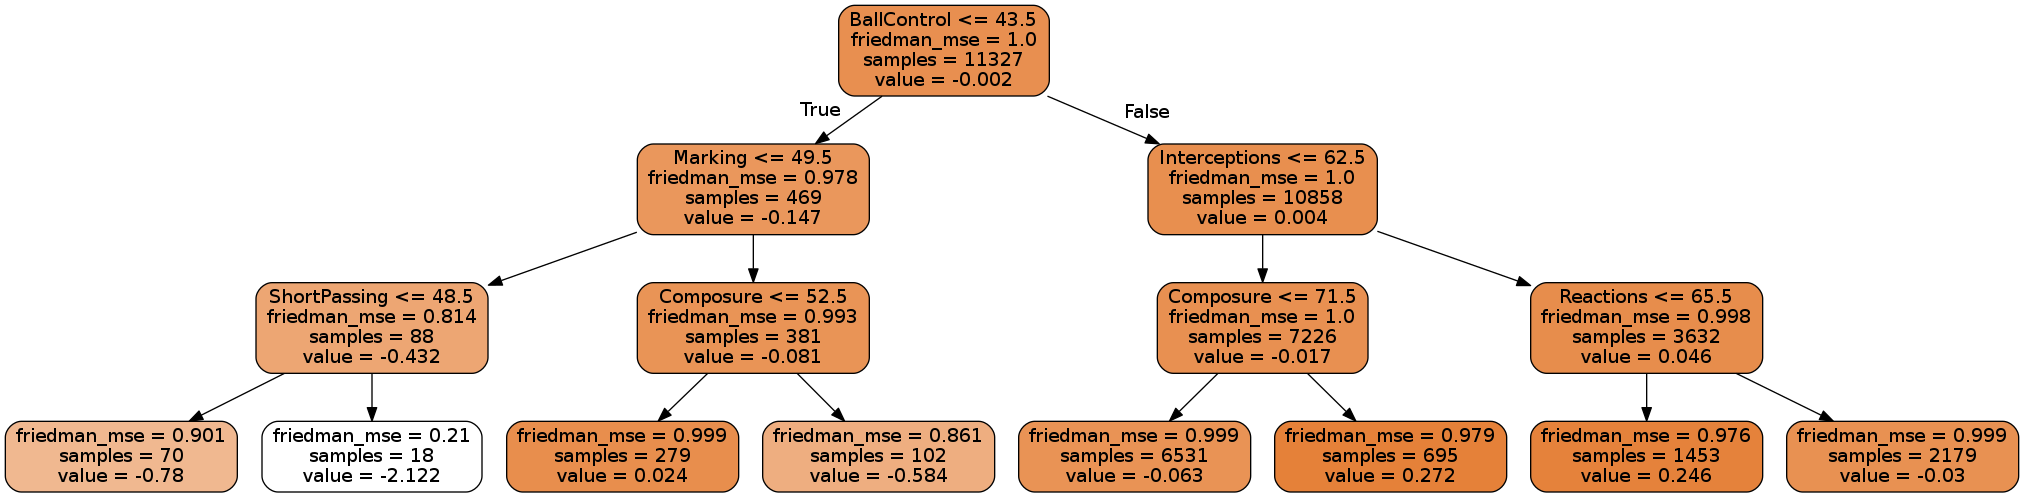

In [165]:
# Display the tree
Image(filename='/users/samuelgiddins/desktop/fifa_ml_project/fifa_tree.png')

## What's my FIFA rating?

In [166]:
print(model.predict(([[75, 30, 70, 60, 50, 70, 65, 30, 70, 55, 75, 50, 24, 40, 80, 65, 90, 40, 45, 50, 80, 30, 55, 30, 20, 60, 80, 30, 50, 40, 1, 2]])))


[61.00818578]
